# Building a model for CO2 forecasting based on the time serie dataset
Solution: Direct multi-step time-series forecasting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

In [13]:
df = pd.read_csv("../datasets/Time-series-datasets/co2.csv",sep=',')
df.head()

,time,co2
0,1958-03-29,316.1
1,1958-04-05,317.3
2,1958-04-12,317.6
3,1958-04-19,317.5
4,1958-04-26,316.4


## Preprocessing

In [3]:
print("Null count:\n", df.isnull().sum())
print("NA count:\n",df.isna().sum())

Null count:
 time     0
co2     59
dtype: int64
NA count:
 time     0
co2     59
dtype: int64


In [14]:
df['time'] = pd.to_datetime(df['time'])
df['co2'] = df['co2'].interpolate()

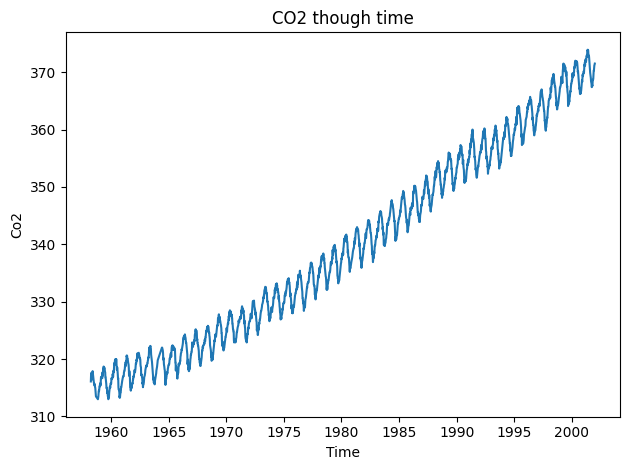

In [15]:
fig, ax = plt.subplots()

ax.set_title("CO2 though time")
# ax.plot(df['time'], df['co2'])
ax.plot(df['time'], df['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('Co2')
fig.tight_layout()
plt.show()

In [17]:
# Create time-seriese data
window_size = 5 # Lượng dữ liệu train để dự đoán cho tuần tới
target_size=3 # Lượng co2 dự đoán (trong 3 tuần)
count = 1

while count < window_size:
    df[f'co2_{count}'] = df['co2'].shift(-count)
    count += 1

count = 0
while count < target_size:
    df[f'target_{count}'] = df[f'co2'].shift(-count-window_size)
    count += 1

df = df.dropna(axis=0)

In [19]:
df.head(10)

,time,co2,co2_1,co2_2,co2_3,co2_4,target_0,target_1,target_2
0,1958-03-29,316.10,317.30,317.60,317.50,316.40,316.90,317.20,317.50
1,1958-04-05,317.30,317.60,317.50,316.40,316.90,317.20,317.50,317.90
2,1958-04-12,317.60,317.50,316.40,316.90,317.20,317.50,317.90,317.55
3,1958-04-19,317.50,316.40,316.90,317.20,317.50,317.90,317.55,317.20
4,1958-04-26,316.40,316.90,317.20,317.50,317.90,317.55,317.20,316.85
5,1958-05-03,316.90,317.20,317.50,317.90,317.55,317.20,316.85,316.50
6,1958-05-10,317.20,317.50,317.90,317.55,317.20,316.85,316.50,316.15
7,1958-05-17,317.50,317.90,317.55,317.20,316.85,316.50,316.15,315.80
8,1958-05-24,317.90,317.55,317.20,316.85,316.50,316.15,315.80,315.80
9,1958-05-31,317.55,317.20,316.85,316.50,316.15,315.80,315.80,315.40


In [20]:
df.tail(6)

,time,co2,co2_1,co2_2,co2_3,co2_4,target_0,target_1,target_2
2271,2001-10-06,367.8,367.6,368.1,368.7,368.7,368.8,369.7,370.3
2272,2001-10-13,367.6,368.1,368.7,368.7,368.8,369.7,370.3,370.3
2273,2001-10-20,368.1,368.7,368.7,368.8,369.7,370.3,370.3,370.8
2274,2001-10-27,368.7,368.7,368.8,369.7,370.3,370.3,370.8,371.2
2275,2001-11-03,368.7,368.8,369.7,370.3,370.3,370.8,371.2,371.3
2276,2001-11-10,368.8,369.7,370.3,370.3,370.8,371.2,371.3,371.5


In [ ]:
# Drop những hàng cuối bị NaN
df = df.dropna(axis=0)

In [30]:
df.tail(6)

,time,co2,co2_1,co2_2,co2_3,co2_4,target_0,target_1,target_2
2271,2001-10-06,367.8,367.6,368.1,368.7,368.7,368.8,369.7,370.3
2272,2001-10-13,367.6,368.1,368.7,368.7,368.8,369.7,370.3,370.3
2273,2001-10-20,368.1,368.7,368.7,368.8,369.7,370.3,370.3,370.8
2274,2001-10-27,368.7,368.7,368.8,369.7,370.3,370.3,370.8,371.2
2275,2001-11-03,368.7,368.8,369.7,370.3,370.3,370.8,371.2,371.3
2276,2001-11-10,368.8,369.7,370.3,370.3,370.8,371.2,371.3,371.5


### Split data
- Features & target
- Train & test

In [37]:
dropped_cols = ['time'] + ['target_{}'.format(i) for i in range(target_size)]
X = df.drop(dropped_cols, axis=1)
X.head()

,co2,co2_1,co2_2,co2_3,co2_4
0,316.1,317.3,317.6,317.5,316.4
1,317.3,317.6,317.5,316.4,316.9
2,317.6,317.5,316.4,316.9,317.2
3,317.5,316.4,316.9,317.2,317.5
4,316.4,316.9,317.2,317.5,317.9


In [38]:
y  = df[['target_{}'.format(i) for i in range(target_size)]]
y

,target_0,target_1,target_2
0,316.90,317.20,317.50
1,317.20,317.50,317.90
2,317.50,317.90,317.55
3,317.90,317.55,317.20
4,317.55,317.20,316.85
...,...,...,...
2272,369.70,370.30,370.30
2273,370.30,370.30,370.80
2274,370.30,370.80,371.20
2275,370.80,371.20,371.30


In [39]:
print(X.shape)
print(y.shape)

(2277, 5)
(2277, 3)


In [40]:
# Split into training & testing
train_ratio = 0.8
num_of_samples = X.shape[0]

training_size = int(num_of_samples * train_ratio)

# X_train = X.iloc[:X_train_size,:]
X_train = X[:training_size]
X_test = X[training_size:]
y_train = y[:training_size]
y_test = y[training_size:]

In [41]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1821, 5)
(1821, 3)
(456, 5)
(456, 3)


### Building models
Use multiple models

In [43]:
y_train

,target_0,target_1,target_2
0,316.90,317.20,317.50
1,317.20,317.50,317.90
2,317.50,317.90,317.55
3,317.90,317.55,317.20
4,317.55,317.20,316.85
...,...,...,...
1816,357.30,357.60,358.30
1817,357.60,358.30,358.50
1818,358.30,358.50,358.10
1819,358.50,358.10,358.80


In [48]:
regs = [LinearRegression() for _ in range(target_size)]

for i, reg in enumerate(regs):
    reg.fit(X_train, y_train[f'target_{i}'])

In [69]:
# for i, reg in enumerate(regs):
r2 = []
mae = []
mse = []
y_preds = []
for i, reg in enumerate(regs):
    y_pred = reg.predict(X_test)
    y_preds.append(y_pred)
    r2.append(r2_score(y_test[f'target_{i}'], y_pred))
    mae.append(mean_absolute_error(y_test[f'target_{i}'], y_pred))
    mse.append(mean_squared_error(y_test[f'target_{i}'], y_pred))
    
print(r2)
print(mae)
print(mse)

[0.990694183549828, 0.9823771406805402, 0.9728273214391037]
[0.3618741479836224, 0.5058913973664146, 0.6465162623791856]
[0.2210146976579318, 0.41917947971120406, 0.6476309152613045]


### Visualization

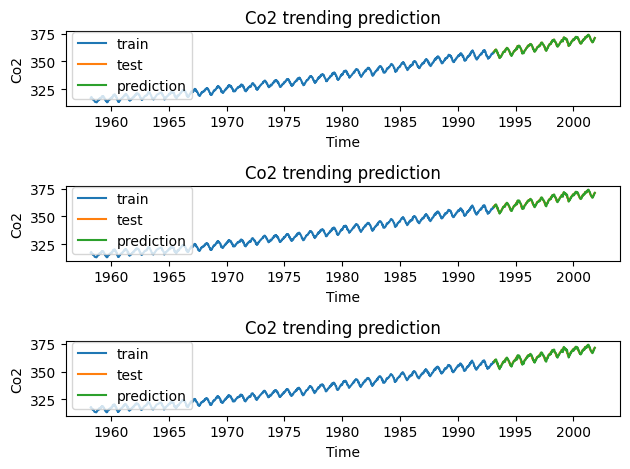

In [70]:
fg, ax = plt.subplots(3,1)



for i in range(target_size):
    ax[i].set_title("Co2 trending prediction")
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Co2")
    ax[i].plot(df['time'][:training_size], y_train[f'target_{i}'], label='train')
    ax[i].plot(df['time'][training_size:], y_test[f'target_{i}'], label='test')
    ax[i].plot(df['time'][training_size:], y_preds[i], label='prediction')
    ax[i].legend()

plt.tight_layout()
plt.show()